# Setup

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, XLMRobertaConfig, BertModel, get_linear_schedule_with_warmup
from transformers.modeling_utils import PretrainedConfig
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, naive_bayes, pipeline
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import random
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from utils.functions import group_texts, sentiment_code, topic_code,subcode_trans, extract_code, party_deu, clean_text, copy_weights, sentiment_code_coalition, topic_code_coalition
from utils.functions import train_loop, eval_loop, test_loop, tokenize_function, cmp_scale, scale_func, d2v_reduct, check_weights_similar, compare_architectures, get_architecture_details
from utils.models import TIPredictWithDualAttention
from sklearn.utils.class_weight import compute_class_weight
from safetensors.torch import load_file
import pickle
import nltk
from sklearn.decomposition import PCA
from huggingface_hub import login
from peft import PeftModel, PeftConfig
from safetensors import safe_open
from safetensors.torch import save_file
#nltk.download('stopwords') ## Remove comments and do it once if you haven't

In [2]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [3]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)


# Small test of BERT embeddings

In [4]:
model_name = 'bert-base-cased'

In [5]:
model = BertModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
sentence_a = 'I went to the river bank'
sentence_b = 'I went to the bank by the river'
tok_a = tokenizer(sentence_a, return_tensors='pt')
tok_b = tokenizer(sentence_b, return_tensors='pt')

In [7]:
tok_a

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 2186, 3085,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
tok_b

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 3085, 1118, 1103, 2186,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
with torch.no_grad():
    outputs_a = model(**tok_a)
    outputs_b = model(**tok_b)
# Extract word embeddings from the last hidden layer
last_hidden_states_a = outputs_a.last_hidden_state
last_hidden_states_b = outputs_b.last_hidden_state

# Extract the word embedding for the first token (CLS token)
word_embedding_a = last_hidden_states_a[:, -2, :] ## 0 is the CLS token, river is the last token
word_embedding_b = last_hidden_states_b[:, 5, :]

In [10]:
np.corrcoef(word_embedding_a.numpy(), word_embedding_b.numpy()).round(2)

array([[1.  , 0.64],
       [0.64, 1.  ]])

# Implementation

### Data preparation

In [11]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8", dtype = {2: 'str', 18:'str'})

In [12]:
manifesto = manifesto[(manifesto.cmp_code.notna()) & ~(manifesto.cmp_code.isin(['H']))].reset_index(drop=True)
len(manifesto)

883323

In [13]:
manifesto['sentiment'] = manifesto['cmp_code'].apply(sentiment_code)
manifesto['topic'] = manifesto['cmp_code'].apply(topic_code)
manifesto['election'] = manifesto['date'].astype(str).str[:4]

In [14]:
manifesto.groupby(['topic','sentiment']).count()

text  text_en  cmp_code  eu_code  \
topic                       sentiment                                       
Agriculture - Protectionism left        19310    18296     19310      193   
                            right        2181     2030      2181        9   
Civil Rights                left        36107    34285     36107       11   
                            right       52426    52025     52426       57   
Decentralization            left         2191     2191      2191        0   
                            right       35720    31305     35720      264   
Economics                   left        52420    50090     52420       80   
                            right       37940    36785     37940       62   
Education                   left        45505    44167     45505       10   
                            right         638      625       638        0   
Environment - Growth        left        85092    81928     85092       78   
                            right       10884    10336     10884       37   
European Integration        left        14003    13783     14003        1   
                            right        6090     5968      6090        1   
Immigration                 left        12267    11180     12267       28   
                            right       17979    17888     17979        9   
International Relations     left        27693    26967     27693       24   
                            right        2190     2169      2190        2   
Labour and Social Welfare   left       184420   177051    184420       63   
                            right        6464     6432      6464        1   
Military                    left         4697     4442      4697        9   
                            right       10369    10309     10369       20   
Other                       neutral    216737   208066    216737      202   

                                          pos  manifesto_id   party    date  \
topic                       sentiment                                         
Agriculture - Protectionism left        19310         19310   19310   19310   
                            right        2181          2181    2181    2181   
Civil Rights                left        36107         36107   36107   36107   
                            right       52426         52426   52426   52426   
Decentralization            left         2191          2191    2191    2191   
                            right       35720         35720   35720   35720   
Economics                   left        52420         52420   52420   52420   
                            right       37940         37940   37940   37940   
Education                   left        45505         45505   45505   45505   
                            right         638           638     638     638   
Environment - Growth        left        85092         85092   85092   85092   
                            right       10884         10884   10884   10884   
European Integration        left        14003         14003   14003   14003   
                            right        6090          6090    6090    6090   
Immigration                 left        12267         12267   12267   12267   
                            right       17979         17979   17979   17979   
International Relations     left        27693         27693   27693   27693   
                            right        2190          2190    2190    2190   
Labour and Social Welfare   left       184420        184420  184420  184420   
                            right        6464          6464    6464    6464   
Military                    left         4697          4697    4697    4697   
                            right       10369         10369   10369   10369   
Other                       neutral    216737        216737  216737  216737   

                                       language  source  ...  translation_en  \
topic                       sentiment                    ..

In [15]:
manifesto.groupby('sentiment').count()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,id,country,party_code,countryname,abbrev,name,edate,parfam,topic,election
sentiment,,,,,,,,,,,,,,,,,,,,,
left,483705,464380,483705,497,483705,483705,483705,483705,483705,483705,...,483705,483705,483705,483705,454195,483705,483705,483705,483705,483705
neutral,216737,208066,216737,202,216737,216737,216737,216737,216737,216737,...,216737,216737,216737,216737,203712,216737,216737,216737,216737,216737
right,182881,175872,182881,462,182881,182881,182881,182881,182881,182881,...,182881,182881,182881,182881,174907,182881,182881,182881,182881,182881


In [16]:
len(manifesto[manifesto.topic=="Military"])/len(manifesto)*100 ## minority group: 1.7%

1.7056048580190937

In [17]:
texts = manifesto['text'].tolist()

In [18]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 18.07444502180969
Std length (word) is: 11.17055383287234
Min length (word) is: 1
Max length (word) is: 269


<Axes: >

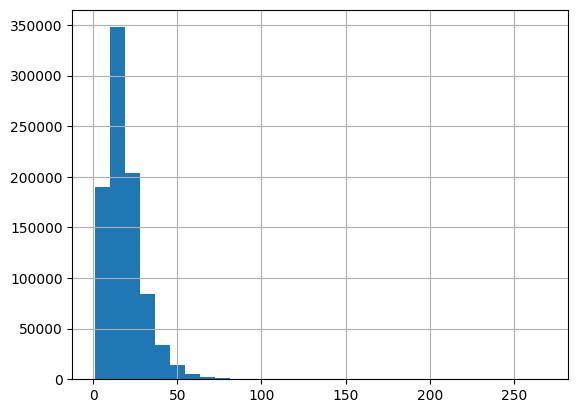

In [19]:
pd.Series(seq_len).hist(bins = 30)

In [20]:
results = group_texts(manifesto, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [21]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [22]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [23]:
manifesto_regrouped.columns = ['text', 'idx', 'country','election', 'party', 'cmp_code']

In [24]:
manifesto_regrouped.head()

,text,idx,country,election,party,cmp_code
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105


In [25]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)


In [26]:
manifesto_regrouped.groupby(['topic','sentiment']).count()

text    idx  country  election  party  \
topic                       sentiment                                           
Agriculture - Protectionism left        7381   7381     7381      7381   7381   
                            right        935    935      935       935    935   
Civil Rights                left       14002  14002    14002     14002  14002   
                            right      19632  19632    19632     19632  19632   
Decentralization            left         934    934      934       934    934   
                            right      13801  13801    13801     13801  13801   
Economics                   left       20294  20294    20294     20294  20294   
                            right      14528  14528    14528     14528  14528   
Education                   left       17314  17314    17314     17314  17314   
                            right        257    257      257       257    257   
Environment - Growth        left       32256  32256    32256     32256  32256   
                            right       4203   4203     4203      4203   4203   
European Integration        left        5481   5481     5481      5481   5481   
                            right       2428   2428     2428      2428   2428   
Immigration                 left        4817   4817     4817      4817   4817   
                            right       6699   6699     6699      6699   6699   
International Relations     left       10211  10211    10211     10211  10211   
                            right        898    898      898       898    898   
Labour and Social Welfare   left       70547  70547    70547     70547  70547   
                            right       2570   2570     2570      2570   2570   
Military                    left        1798   1798     1798      1798   1798   
                            right       3800   3800     3800      3800   3800   
Other                       neutral    82626  82626    82626     82626  82626   

                                       cmp_code  
topic                       sentiment            
Agriculture - Protectionism left           7381  
                            right           935  
Civil Rights                left          14002  
                            right         19632  
Decentralization            left            934  
                            right         13801  
Economics                   left          20294  
                            right         14528  
Education                   left          17314  
                            right           257  
Environment - Growth        left          32256  
                            right          4203  
European Integration        left           5481  
                            right          2428  
Immigration                 left           4817  
                            right          6699  
International Relations     left          10211  
                            right           898  
Labour and Social Welfare   left          70547  
                            right          2570  
Military                    left           1798  
                            right          3800  
Other                       neutral       82626

In [27]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 74.3312271051415
Std length (word) is: 36.82022801372765
Min length (word) is: 1
Max length (word) is: 374


<Axes: >

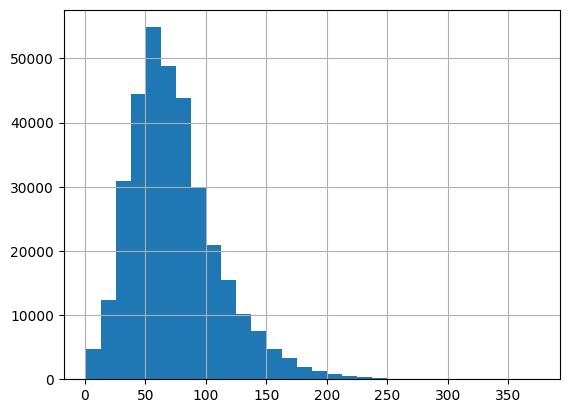

In [28]:
pd.Series(seq_len).hist(bins = 30)

In [29]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8', index=False)
manifesto.to_csv('data/temps/manifesto.csv', encoding='utf-8', index=False)

### Fine-tuning with manual left-right-neutral scheme (Kluever + CMP); grouped data

In [30]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8', dtype={2:'str',18: 'str'})
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [31]:
manifesto_reduced = manifesto_regrouped[['topic','sentiment','text']].reset_index(drop=True)

In [32]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [33]:
manifesto_reduced['topic_sentiment'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['sentiment']

In [34]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_sentiment')



Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

In [35]:
## Save class labels
import pickle
topic_labels = manifesto_dataset.features['topic'].names
file_path = 'data/temps/topic_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(topic_labels, fp)

sentiment_labels = manifesto_dataset.features['sentiment'].names
file_path = 'data/temps/sentiment_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(sentiment_labels, fp)

In [36]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_sentiment', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_sentiment', seed=seed_val )

In [37]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 212569
    })
    test: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 33742
    })
    eval: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 91101
    })
})

In [38]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text', 'topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/212569 [00:00<?, ? examples/s]

Map:   0%|          | 0/33742 [00:00<?, ? examples/s]

Map:   0%|          | 0/91101 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [39]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=8, shuffle=False, collate_fn = data_collator)

In [40]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)



In [41]:
model.get_trainable_params(return_count=True)

18657954

In [42]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [43]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic')
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
loss: 1.976190  [ 1600/212569].
Elapsed time: 0:00:24, Estimated remaining time: 0:52:01
loss: 1.864248  [ 3200/212569].
Elapsed time: 0:00:45, Estimated remaining time: 0:49:26
loss: 1.812533  [ 4800/212569].
Elapsed time: 0:01:07, Estimated remaining time: 0:48:42
loss: 1.787140  [ 6400/212569].
Elapsed time: 0:01:29, Estimated remaining time: 0:47:34
loss: 1.769979  [ 8000/212569].
Elapsed time: 0:01:50, Estimated remaining time: 0:47:03
loss: 1.759474  [ 9600/212569].
Elapsed time: 0:02:12, Estimated remaining time: 0:46:30
loss: 1.749783  [11200/212569].
Elapsed time: 0:02:34, Estimated remaining time: 0:46:15
loss: 1.743277  [12800/212569].
Elapsed time: 0:02:57, Estimated remaining time: 0:46:03
loss: 1.710520  [14400/212569].
Elapsed time: 0:03:20, Estimated remaining time: 0:45:50
loss: 1.656924  [16000/212569].
Elapsed time: 0:03:42, Estimated remaining time: 0:45:22
loss: 1.597158  [17600/212569].
Elapsed time: 0:04:04, Estimated remaining time: 0:45:04

In [44]:
state_dict = model.state_dict()
save_file(state_dict, 'results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')

### Scaling party positions in Germany

#### Reload files and compute LR-score by MARPOR for comparison

In [45]:
manifesto.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,country,party_code,countryname,abbrev,name,edate,parfam,sentiment,topic,election
0,Miljöpartiet de Gröna går till val på en polit...,The Green Party is running on a policy for mor...,408,NaN,1,11110_200609,11110,200609,swedish,MARPOR,...,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10,neutral,Other,2006
1,"fler företag,","more businesses, a",402,NaN,2,11110_200609,11110,200609,swedish,MARPOR,...,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10,right,Economics,2006
2,"levande landsbygd,","vibrant countryside,",301,NaN,3,11110_200609,11110,200609,swedish,MARPOR,...,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10,right,Decentralization,2006
3,nya livschanser,new life chances,504,NaN,4,11110_200609,11110,200609,swedish,MARPOR,...,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006
4,och ett långsiktigt miljöansvar.,and long-term environmental responsibility.,501,NaN,5,11110_200609,11110,200609,swedish,MARPOR,...,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006


In [46]:
manifesto_regrouped.head()

,text,idx,country,election,party,cmp_code,sentiment,topic
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104.0,right,Military
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military


In [47]:
lr_kws = dict({'left': 'left', 'right': 'right'})

In [48]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto, text_var = 'text', group_vars=['countryname','party','election'], lr_kws = lr_kws, sent_var='sentiment')

#### Scaling positions with ContextScale

In [49]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)


In [50]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)


In [51]:
loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [52]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/337412 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [53]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)

In [54]:
## Compute position scores
position_scores, pred_topics, pred_sentiment = scale_func(pred_dataloader, scaling_model, device, topic_label='topic')

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 0:00:55, Estimated remaining time: 0:37:34
Elapsed time: 0:02:11, Estimated remaining time: 0:43:52
Elapsed time: 0:03:36, Estimated remaining time: 0:47:05
Elapsed time: 0:04:58, Estimated remaining time: 0:47:29
Elapsed time: 0:06:21, Estimated remaining time: 0:47:15
Elapsed time: 0:07:42, Estimated remaining time: 0:46:27
Elapsed time: 0:09:15, Estimated remaining time: 0:46:29
Elapsed time: 0:10:25, Estimated remaining time: 0:44:31
Elapsed time: 0:11:44, Estimated remaining time: 0:43:16
Elapsed time: 0:12:48, Estimated remaining time: 0:41:11
Elapsed time: 0:13:45, Estimated remaining time: 0:38:58
Elapsed time: 0:14:52, Estimated remaining time: 0:37:22
Elapsed time: 0:15:53, Estimated remaining time: 0:35:38
Elapsed time: 0:16:53, Estimated remaining time: 0:33:58
Elapsed time: 0:17:56, Estimated remaining time: 0:32:29
Elapsed time: 0:19:05, Estimated remaining time

In [55]:
list_names = manifesto_dataset.features['sentiment'].names
name_sentiment_dict = dict([(x,y) for x,y in enumerate(list_names)])
list_names = manifesto_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])


In [56]:
name_topic_dict

{0: 'Agriculture - Protectionism',
 1: 'Civil Rights',
 2: 'Decentralization',
 3: 'Economics',
 4: 'Education',
 5: 'Environment - Growth',
 6: 'European Integration',
 7: 'Immigration',
 8: 'International Relations',
 9: 'Labour and Social Welfare',
 10: 'Military',
 11: 'Other'}

In [57]:
manifesto_regrouped.loc[:,'position_scores'] = position_scores.flatten()
manifesto_regrouped.loc[:,'pred_sentiment_index'] = pred_sentiment
manifesto_regrouped.loc[:,'pred_sentiment'] = manifesto_regrouped.pred_sentiment_index.map(name_sentiment_dict)
manifesto_regrouped.loc[:,'pred_topic_index'] = pred_topics
manifesto_regrouped.loc[:,'pred_topic'] = manifesto_regrouped.pred_topic_index.map(name_topic_dict)

In [58]:
columns  =['country','party', 'election','mean_score', 'se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_regrouped.groupby(['country','party','election']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                             str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [59]:
df['lr_log'] = logscale
df['lr_abs'] = absscale



In [60]:
np.corrcoef(df['lr_log'], df['mean_score'])

array([[1.        , 0.89727398],
       [0.89727398, 1.        ]])

In [61]:
## Save df 
df.to_csv('data/py_outputs/cs_gen.csv', index=False)

In [62]:
manifesto_regrouped.head()

,text,idx,country,election,party,cmp_code,sentiment,topic,position_scores,pred_sentiment_index,pred_sentiment,pred_topic_index,pred_topic
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104.0,right,Military,-0.334583,0,left,10,Military
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.735754,0,left,10,Military
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,0.450315,2,right,10,Military
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.519948,0,left,10,Military
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.475698,0,left,10,Military


In [63]:
labels = manifesto_dataset.to_pandas()['sentiment'].tolist()
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_sentiment, average=None)
matrix = confusion_matrix(labels, pred_sentiment)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [64]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.92,0.91,0.93,0.93
1,0.85,0.86,0.83,0.83
2,0.82,0.83,0.82,0.82


In [65]:
manifesto_regrouped.to_csv("data/py_outputs/cs_topic.csv", index=False)

# Validity checks

### Same dataset

#### Test set

In [66]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)

loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [67]:
res_table_topic, res_table_sentiment = test_loop(test_dataloader, scaling_model, device=device, topic_var='topic',sentiment_var='sentiment')

In [68]:
res_table_topic.loc[:,'topic'] = res_table_topic.index.map(name_topic_dict)
res_table_sentiment.loc[:,'sentiment'] = res_table_sentiment.index.map(name_sentiment_dict)

In [69]:
res_table_topic

,f1,precision,recall,accuracy,topic
0,0.82,0.84,0.81,0.81,Agriculture - Protectionism
1,0.77,0.77,0.77,0.77,Civil Rights
2,0.78,0.80,0.76,0.76,Decentralization
3,0.80,0.80,0.80,0.80,Economics
4,0.88,0.87,0.90,0.90,Education
5,0.89,0.88,0.90,0.90,Environment - Growth
6,0.86,0.85,0.87,0.87,European Integration
7,0.76,0.77,0.75,0.75,Immigration
8,0.84,0.84,0.85,0.85,International Relations
9,0.87,0.86,0.88,0.88,Labour and Social Welfare


In [70]:
np.mean(res_table_topic['f1'])

0.8316666666666667

In [71]:
res_table_sentiment

,f1,precision,recall,accuracy,sentiment
0,0.91,0.90,0.92,0.92,left
1,0.82,0.84,0.81,0.81,neutral
2,0.80,0.81,0.79,0.79,right


In [72]:
np.mean(res_table_sentiment['f1'])

0.8433333333333334

In [73]:
res_table_topic.to_csv('results/classification results/manifesto_test_topic.csv', index=False, encoding='utf-8')
res_table_sentiment.to_csv('results/classification results/manifesto_test_sent.csv', index=False, encoding='utf-8')

#### Different languages

In [74]:
manifesto_test = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8")

In [75]:
manifesto_test

,text,cmp_code,eu_code,pos,manifesto_id,party,date,language,annotations,translation_en,country,party_code,countryname,abbrev,name,edate,parfam
0,安倍政権の暴走ストップ！,H,NaN,1,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
1,国民の声が生きる新しい政治を,H,NaN,2,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
2,日本共産党の総選挙政策,H,NaN,3,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
3,日本共産党,H,NaN,4,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
4,安倍政権の暴走ストップ、政治を変えるチャンスです……,305.1,NaN,5,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97166,-만성폐질환이 동네의원에서 효과적으로 관리되도록 일차의료교육-상담사업실시,504,NaN,1791,113631_202004,113631,202004,korean,True,False,11,11363,NaN,NaN,NaN,NaN,NaN
97167,중증폐질환에 대한 치료가 적시에 효과적으로 이루어지도록 건강보험확대,504,NaN,1792,113631_202004,113631,202004,korean,True,False,11,11363,NaN,NaN,NaN,NaN,NaN
97168,.폐암에 대한 지원확대,504,NaN,1793,113631_202004,113631,202004,korean,True,False,11,11363,NaN,NaN,NaN,NaN,NaN
97169,국립암센터 폐암 관련 의료진 및 치료시설 대폭 확충해 전문성과치료역량제고,504,NaN,1794,113631_202004,113631,202004,korean,True,False,11,11363,NaN,NaN,NaN,NaN,NaN


In [76]:
manifesto_test = manifesto_test[(manifesto_test.cmp_code.notna()) & ~(manifesto_test.cmp_code == 'H')].reset_index(drop=True)

In [77]:
manifesto_test['sentiment'] = manifesto['cmp_code'].apply(sentiment_code)
manifesto_test['topic'] = manifesto['cmp_code'].apply(topic_code)
manifesto_test['election'] = manifesto['date'].astype(str).str[:4]

In [78]:
results = group_texts(manifesto_test, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [79]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [80]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [81]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'cmp_code']

In [82]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code
0,"Ropný zlom je moment, kdy nastane vrchol světo...",Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
1,Nejzranitelnější z ekonomik je trh Spojených s...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
2,Na konci tohoto přístupu mohou být prázdné nád...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
3,Když jsme před čtyřmi lety vstupovali do Posla...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
4,"Změny, které se sice většinou nedostanou na pr...",Czech Republic;2013;82110;000,Czech Republic,2013,82110,000


In [83]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)


In [84]:
manifesto_regrouped.groupby(['topic','sentiment']).count()

text  country_election_party_code  \
topic                       sentiment                                       
Agriculture - Protectionism left        1354                         1354   
                            right        128                          128   
Civil Rights                left        1050                         1050   
                            right       1837                         1837   
Decentralization            left          56                           56   
                            right        747                          747   
Economics                   left        2060                         2060   
                            right       2282                         2282   
Education                   left        1571                         1571   
                            right          4                            4   
Environment - Growth        left        1394                         1394   
                            right       1105                         1105   
European Integration        left         233                          233   
                            right         69                           69   
Immigration                 left         193                          193   
                            right        882                          882   
International Relations     left        1360                         1360   
                            right         68                           68   
Labour and Social Welfare   left        4333                         4333   
                            right         92                           92   
Military                    left         156                          156   
                            right        581                          581   
Other                       neutral    10793                        10793   

                                       country  election  party  cmp_code  
topic                       sentiment                                      
Agriculture - Protectionism left          1354      1354   1354      1354  
                            right          128       128    128       128  
Civil Rights                left          1050      1050   1050      1050  
                            right         1837      1837   1837      1837  
Decentralization            left            56        56     56        56  
                            right          747       747    747       747  
Economics                   left          2060      2060   2060      2060  
                            right         2282      2282   2282      2282  
Education                   left          1571      1571   1571      1571  
                            right            4         4      4         4  
Environment - Growth        left          1394      1394   1394      1394  
                            right         1105      1105   1105      1105  
European Integration        left           233       233    233       233  
                            right           69        69     69        69  
Immigration                 left           193       193    193       193  
                            right          882       882    882       882  
International Relations     left          1360      1360   1360      1360  
                            right           68        68     68        68  
Labour and Social Welfare   left          4333      4333   4333      4333  
                            right           92        92     92        92  
Military                    left           156       156    156       156  
                            right          581       581    581       581  
Other                       neutral      10793     10793  10793     10793

In [85]:
manifesto_reduced = manifesto_regrouped[['topic','sentiment','text']].reset_index(drop=True)

In [86]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [87]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')



Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

In [88]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/32348 [00:00<?, ? examples/s]

In [89]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)

loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [90]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)

In [91]:
res_table_topic_2, res_table_sentiment_2 = test_loop(test_dataloader, scaling_model, device=device, topic_var='topic',sentiment_var='sentiment')

In [92]:
res_table_topic_2.loc[:,'topic'] = res_table_topic_2.index.map(name_topic_dict)
res_table_sentiment_2.loc[:,'sentiment'] = res_table_sentiment_2.index.map(name_sentiment_dict)

In [93]:
res_table_topic_2

,f1,precision,recall,accuracy,topic
0,0.82,0.84,0.81,0.81,Agriculture - Protectionism
1,0.77,0.77,0.77,0.77,Civil Rights
2,0.78,0.80,0.76,0.76,Decentralization
3,0.80,0.80,0.80,0.80,Economics
4,0.88,0.87,0.90,0.90,Education
5,0.89,0.88,0.90,0.90,Environment - Growth
6,0.86,0.85,0.87,0.87,European Integration
7,0.76,0.77,0.75,0.75,Immigration
8,0.84,0.84,0.85,0.85,International Relations
9,0.87,0.86,0.88,0.88,Labour and Social Welfare


In [94]:
np.mean(res_table_topic_2['f1'])

0.8316666666666667

In [95]:
res_table_sentiment_2

,f1,precision,recall,accuracy,sentiment
0,0.91,0.90,0.92,0.92,left
1,0.82,0.84,0.81,0.81,neutral
2,0.80,0.81,0.79,0.79,right


In [96]:
np.mean(res_table_sentiment_2['f1'])

0.8433333333333334

In [97]:
res_table_topic_2.to_csv('results/classification results/manifesto_lang_topic.csv', index=False, encoding='utf-8')
res_table_sentiment_2.to_csv('results/classification results/manifesto_lang_sent.csv', index=False, encoding='utf-8')

### COALITIONAGREE, same coding style

#### No supervision

In [98]:
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [99]:
coalitionagree.head()

,sentence,domain,category2,category3,level,id,country_init,cabinet_year,country
0,1. Abkommen vom Dezember 1945,8,800,80000,0,1,AT,1945,Austria
1,Der Proporz soll nicht nur bei der Bildung der...,9,900,90001,0,2,AT,1945,Austria
2,Staatssekretäre sollen nur in Ausnahmefällen n...,9,900,90004,0,3,AT,1945,Austria
3,Das Programm der Parteien soll in der Erklärun...,9,900,90001,0,4,AT,1945,Austria
4,Die Österreichische Volkspartei bietet den Soz...,9,900,90002,0,5,AT,1945,Austria


In [100]:
results = group_texts(coalitionagree, ['country','cabinet_year','category2','category3'], 'sentence', max_group_factor = 5)

In [101]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split(';', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'cmp_short','cmp_long']


In [102]:
coalition_regrouped.head()

,text,labels,country,year,cmp_short,cmp_long
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602


In [103]:
coalition_regrouped['sentiment'] = coalition_regrouped.apply(lambda x: sentiment_code_coalition(x['cmp_short'], x['cmp_long']), axis=1)
coalition_regrouped['topic'] = coalition_regrouped['cmp_short'].apply(topic_code_coalition)

In [104]:
coalition_regrouped.to_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8',index=False)

In [105]:
coalition_regrouped.groupby(['topic','sentiment']).count()

text  labels  country   year  \
topic                       sentiment                                  
Agriculture - Protectionism left         877     877      877    877   
                            right         86      86       86     86   
Civil Rights                left        2232    2232     2232   2232   
                            neutral      392     392      392    392   
                            right       2163    2163     2163   2163   
Decentralization            left         121     121      121    121   
                            right       1542    1542     1542   1542   
Economics                   left        2025    2025     2025   2025   
                            right       2592    2592     2592   2592   
Education                   left        1883    1883     1883   1883   
                            right         37      37       37     37   
Environment - Growth        left        2382    2382     2382   2382   
                            right        754     754      754    754   
European Integration        left         862     862      862    862   
                            right         90      90       90     90   
Immigration                 left         485     485      485    485   
                            right        429     429      429    429   
International Relations     left        1438    1438     1438   1438   
                            right         36      36       36     36   
Labour and Social Welfare   left        5318    5318     5318   5318   
                            right        502     502      502    502   
Military                    left         211     211      211    211   
                            right        685     685      685    685   
Other                       neutral    12145   12145    12145  12145   

                                       cmp_short  cmp_long  
topic                       sentiment                       
Agriculture - Protectionism left             877       877  
                            right             86        86  
Civil Rights                left            2232      2232  
                            neutral          392       392  
                            right           2163      2163  
Decentralization            left             121       121  
                            right           1542      1542  
Economics                   left            2025      2025  
                            right           2592      2592  
Education                   left            1883      1883  
                            right             37        37  
Environment - Growth        left            2382      2382  
                            right            754       754  
European Integration        left             862       862  
                            right             90        90  
Immigration                 left             485       485  
                            right            429       429  
International Relations     left            1438      1438  
                            right             36        36  
Labour and Social Welfare   left            5318      5318  
                            right            502       502  
Military                    left             211       211  
                            right            685       685  
Other                       neutral        12145     12145

In [106]:
cagree_reduced = coalition_regrouped[['sentiment', 'topic','text']]

In [107]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [108]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [109]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)

In [110]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)

loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [111]:
res_table_topic_3, res_table_sentiment_3 = test_loop(pred_dataloader, scaling_model, device=device, topic_var='topic',sentiment_var='sentiment')

In [112]:
res_table_topic_3.loc[:,'topic'] = res_table_topic_3.index.map(name_topic_dict)
res_table_sentiment_3.loc[:,'sentiment'] = res_table_sentiment_3.index.map(name_sentiment_dict)

In [113]:
res_table_topic_3

,f1,precision,recall,accuracy,topic
0,0.79,0.75,0.82,0.82,Agriculture - Protectionism
1,0.58,0.79,0.46,0.46,Civil Rights
2,0.58,0.53,0.65,0.65,Decentralization
3,0.70,0.67,0.74,0.74,Economics
4,0.79,0.80,0.78,0.78,Education
5,0.79,0.79,0.80,0.80,Environment - Growth
6,0.79,0.77,0.81,0.81,European Integration
7,0.68,0.67,0.70,0.70,Immigration
8,0.81,0.74,0.89,0.89,International Relations
9,0.71,0.66,0.78,0.78,Labour and Social Welfare


In [114]:
np.mean(res_table_topic_3['f1'])

0.7299999999999999

In [115]:
res_table_sentiment_3

,f1,precision,recall,accuracy,sentiment
0,0.82,0.80,0.83,0.83,left
1,0.71,0.74,0.69,0.69,neutral
2,0.69,0.68,0.71,0.71,right


In [116]:
np.mean(res_table_sentiment_3['f1'])

0.7399999999999999

In [117]:
res_table_topic_3.to_csv('results/classification results/cagree_noft_topic.csv', index=False, encoding='utf-8')
res_table_sentiment_3.to_csv('results/classification results/cagree_noft_sent.csv', index=False, encoding='utf-8')

#### 25% supervision

In [ ]:
cagree_reduced.loc[:,'topic_sentiment'] = cagree_reduced.loc[:,'topic'] + '_' + cagree_reduced.loc[:,'sentiment']

In [119]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')
cagree_dataset = cagree_dataset.class_encode_column('topic_sentiment')

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [120]:
train_test = cagree_dataset.train_test_split(test_size=0.75, stratify_by_column='topic_sentiment', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='topic_sentiment', seed=seed_val )

In [121]:
cagree_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
cagree_datasets

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'topic', 'text', 'topic_sentiment'],
        num_rows: 7856
    })
    test: Dataset({
        features: ['sentiment', 'topic', 'text', 'topic_sentiment'],
        num_rows: 29466
    })
    eval: Dataset({
        features: ['sentiment', 'topic', 'text', 'topic_sentiment'],
        num_rows: 1965
    })
})

In [122]:
tokenized_datasets = cagree_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/7856 [00:00<?, ? examples/s]

Map:   0%|          | 0/29466 [00:00<?, ? examples/s]

Map:   0%|          | 0/1965 [00:00<?, ? examples/s]

['sentiment', 'topic', 'input_ids', 'attention_mask']

In [123]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=8, shuffle=False, collate_fn = data_collator)

In [124]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
model.load_state_dict(loaded_tensors)
scaling_model=None

In [125]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sentiment = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()

In [126]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sentiment, criterion_topic, sentiment_var='sentiment',
               topic_var='topic')
    eval_loop(eval_dataloader, model, device, criterion_sentiment, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
loss: 0.772378  [ 1600/ 7856].
Elapsed time: 0:00:20, Estimated remaining time: 0:01:20
loss: 0.701681  [ 3200/ 7856].
Elapsed time: 0:00:41, Estimated remaining time: 0:00:59
loss: 0.664192  [ 4800/ 7856].
Elapsed time: 0:01:02, Estimated remaining time: 0:00:39
loss: 0.628970  [ 6400/ 7856].
Elapsed time: 0:01:21, Estimated remaining time: 0:00:19

  Training epoch took: 0:01:40
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.963400 

Accuracy - Sentiment: 83.0%, Avg loss: 0.963400 

Accuracy - Topic: 82.2%, Avg loss: 0.963400 

Epoch: 2

Training...
loss: 0.418642  [ 1600/ 7856].
Elapsed time: 0:00:21, Estimated remaining time: 0:01:22
loss: 0.434252  [ 3200/ 7856].
Elapsed time: 0:00:41, Estimated remaining time: 0:00:59
loss: 0.435799  [ 4800/ 7856].
Elapsed time: 0:01:01, Estimated remaining time: 0:00:39
loss: 0.431262  [ 6400/ 7856].
Elapsed time: 0:01:21, Estimated remaining time: 0:00:18

  Training epoch took: 0:01:39
Test Error: 
 Accuracy: 83.8%, Avg loss:

In [127]:
state_dict = model.state_dict()
save_file(state_dict, 'results/multilingual/coalitionagree_TIPredictWithDualAttention/model.safetensors')

In [128]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)
loaded_tensors = load_file('results/multilingual/coalitionagree_TIPredictWithDualAttention/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [129]:
res_table_topic_4, res_table_sentiment_4 = test_loop(test_dataloader, scaling_model, device=device, topic_var='topic',sentiment_var='sentiment')

In [130]:
res_table_topic_4.loc[:,'topic'] = res_table_topic_4.index.map(name_topic_dict)
res_table_sentiment_4.loc[:,'sentiment'] = res_table_sentiment_4.index.map(name_sentiment_dict)

In [131]:
res_table_topic_4

,f1,precision,recall,accuracy,topic
0,0.84,0.83,0.85,0.85,Agriculture - Protectionism
1,0.84,0.84,0.83,0.83,Civil Rights
2,0.73,0.71,0.75,0.75,Decentralization
3,0.79,0.78,0.79,0.79,Economics
4,0.89,0.91,0.88,0.88,Education
5,0.86,0.86,0.87,0.87,Environment - Growth
6,0.86,0.85,0.86,0.86,European Integration
7,0.77,0.76,0.77,0.77,Immigration
8,0.87,0.88,0.87,0.87,International Relations
9,0.86,0.86,0.86,0.86,Labour and Social Welfare


In [132]:
res_table_sentiment_4

,f1,precision,recall,accuracy,sentiment
0,0.89,0.89,0.89,0.89,left
1,0.86,0.87,0.85,0.85,neutral
2,0.79,0.78,0.80,0.80,right


In [133]:
res_table_topic_4.to_csv('results/classification results/cagree_25ft_topic.csv', index=False, encoding='utf-8')
res_table_sentiment_4.to_csv('results/classification results/cagree_25ft_sent.csv', index=False, encoding='utf-8')

#### Scale the entire corpus with 25% training

In [134]:
cagree_reduced

,sentiment,topic,text,topic_sentiment
0,neutral,Other,"Abmachungen über die Beamtenbesoldung, ebenso...",Other_neutral
1,neutral,Other,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Other_neutral
2,right,Decentralization,über die Behandlung der Nationalsozialisten,Decentralization_right
3,left,Economics,sowie über die Verstaatlichung werden in Aussi...,Economics_left
4,left,Education,Die Schaffung eines einheitlichen Dienst- und ...,Education_left
...,...,...,...,...
39282,left,Civil Rights,Sverige ska säkra de nationella minoriteternas...,Civil Rights_left
39283,left,Civil Rights,Personer med funktionsnedsättning ska ha möjli...,Civil Rights_left
39284,left,Civil Rights,hbtq-personer,Civil Rights_left
39285,left,Civil Rights,"särskilt kvinnor, Insatser för kvinnors egenfö...",Civil Rights_left


In [135]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [136]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text', 'topic_sentiment'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [137]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)

In [138]:
position_scores, pred_topics, pred_sentiment = scale_func(full_dataloader, scaling_model, device)

Start predicting labels...
Labels for topic are not provided. Using predicted topic labels for position scaling instead!
Elapsed time: 0:01:16, Estimated remaining time: 0:04:57
Elapsed time: 0:02:29, Estimated remaining time: 0:03:37
Elapsed time: 0:03:34, Estimated remaining time: 0:02:17
Elapsed time: 0:04:42, Estimated remaining time: 0:01:04
Start computing position scores


In [139]:
cagree_25 = coalition_regrouped.copy()

In [140]:
cagree_25.loc[:,'position_scores_25'] = position_scores.flatten()
cagree_25.loc[:,'pred_topics_25'] = pred_topics
cagree_25.loc[:,'pred_sentiment_25'] = pred_sentiment



In [141]:
labels = cagree_dataset['sentiment']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_sentiment, average=None)
matrix = confusion_matrix(labels, pred_sentiment)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [142]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.90,0.90,0.90,0.90
1,0.88,0.89,0.87,0.87
2,0.81,0.80,0.82,0.82


In [143]:
labels = cagree_dataset['topic']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_topics, average=None)
matrix = confusion_matrix(labels, pred_sentiment)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [144]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.86,0.85,0.86,0.90
1,0.86,0.86,0.85,0.13
2,0.76,0.74,0.78,0.79
3,0.81,0.81,0.82,0.00
4,0.91,0.92,0.90,0.00
5,0.88,0.88,0.88,0.00
6,0.87,0.86,0.89,0.00
7,0.79,0.79,0.79,0.00
8,0.89,0.90,0.88,0.00
9,0.88,0.88,0.88,0.00


In [145]:
cagree_25.loc[:,'topic_25'] = cagree_25.pred_topics_25.map(name_topic_dict)
cagree_25.loc[:,'sentiment_25'] = cagree_25.pred_sentiment_25.map(name_sentiment_dict)


In [146]:
cagree_25.head()

,text,labels,country,year,cmp_short,cmp_long,sentiment,topic,position_scores_25,pred_topics_25,pred_sentiment_25,topic_25,sentiment_25
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301,neutral,Other,-0.054090,11,1,Other,neutral
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303,neutral,Other,0.143743,11,2,Other,right
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506,right,Decentralization,-0.072434,11,0,Other,left
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301,left,Economics,0.323385,3,2,Economics,right
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602,left,Education,-0.464893,4,0,Education,left


In [147]:
cagree_25.to_csv('data/py_outputs/cagree_scaled_25.csv', index=False)

#### Scale the COALITIONAGREE corpus with full labels information (for official release)

In [4]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [5]:
coalition_regrouped = pd.read_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8')

In [ ]:
coalition_regrouped.head()

,text,labels,country,year,cmp_short,cmp_long,sentiment,topic
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301,neutral,Other
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303,neutral,Other
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506,right,Decentralization
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301,left,Economics
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602,left,Education


In [6]:
cagree_reduced = coalition_regrouped[['sentiment', 'topic','text']].copy()

In [7]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [8]:
## Load pre-trained models
num_topics = 12
num_sentiments = 3
model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)



In [9]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

['sentiment', 'topic', 'input_ids', 'attention_mask']

In [10]:
train_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn = data_collator)
pred_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)


In [11]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion =  nn.CrossEntropyLoss()


In [12]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion, criterion, sentiment_var='sentiment',
               topic_var='topic')

Epoch: 1

Training...
loss: 1.864777  [ 1600/39287].
Elapsed time: 0:00:19, Estimated remaining time: 0:07:36
loss: 1.792364  [ 3200/39287].
Elapsed time: 0:00:38, Estimated remaining time: 0:07:10
loss: 1.764776  [ 4800/39287].
Elapsed time: 0:00:56, Estimated remaining time: 0:06:44
loss: 1.747082  [ 6400/39287].
Elapsed time: 0:01:15, Estimated remaining time: 0:06:25
loss: 1.727277  [ 8000/39287].
Elapsed time: 0:01:34, Estimated remaining time: 0:06:07
loss: 1.676798  [ 9600/39287].
Elapsed time: 0:01:52, Estimated remaining time: 0:05:48
loss: 1.572595  [11200/39287].
Elapsed time: 0:02:11, Estimated remaining time: 0:05:28
loss: 1.480776  [12800/39287].
Elapsed time: 0:02:29, Estimated remaining time: 0:05:08
loss: 1.399113  [14400/39287].
Elapsed time: 0:02:47, Estimated remaining time: 0:04:48
loss: 1.331495  [16000/39287].
Elapsed time: 0:03:05, Estimated remaining time: 0:04:29
loss: 1.273734  [17600/39287].
Elapsed time: 0:03:23, Estimated remaining time: 0:04:10
loss: 1.22

In [16]:
state_dict = model.state_dict()
save_file(state_dict, 'results/multilingual/coalitionagree_TIPredictWithDualAttention_full/model.safetensors')

In [17]:
position_scores, pred_topics, pred_sentiment = scale_func(pred_dataloader, model, device)

Start predicting labels...
Labels for topic are not provided. Using predicted topic labels for position scaling instead!
Elapsed time: 0:01:16, Estimated remaining time: 0:04:57
Elapsed time: 0:02:27, Estimated remaining time: 0:03:34
Elapsed time: 0:03:31, Estimated remaining time: 0:02:14
Elapsed time: 0:04:37, Estimated remaining time: 0:01:03
Start computing position scores


In [18]:
coalition_regrouped.loc[:,'position_scores_full'] = position_scores.flatten()
coalition_regrouped.loc[:,'pred_topics_full'] = pred_topics
coalition_regrouped.loc[:,'pred_sentiment_full'] = pred_sentiment




In [19]:
coalition_regrouped.head()

,text,labels,country,year,cmp_short,cmp_long,sentiment,topic,position_scores_full,pred_topics_full,pred_sentiment_full
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301,neutral,Other,-0.124793,11,1
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303,neutral,Other,0.100194,11,1
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506,right,Decentralization,-0.049525,11,0
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301,left,Economics,-0.129582,3,0
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602,left,Education,-0.660446,4,0


In [20]:
coalition_regrouped.to_csv('results/datasets/cagree_scaled_full.csv', encoding='utf-8', index=False)

### Adapting to twitter data (Sentiment is not Stance)

#### Adaptation training 

In [101]:
tw_trump = pd.read_csv('data/MOTN/MOTN_responses_groundtruth.csv', encoding='utf-8')
tw_kav = pd.read_csv('data/MOTN/kavanaugh_tweets_groundtruth.csv', encoding='utf-8')
tw_wm = pd.read_csv('data/MOTN/WM_tweets_groundtruth.csv', encoding='utf-8')

In [93]:
tw_trump.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [94]:
tw_kav.head()

,text,sentiment,stance,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,lexicoder_sentiment,vader_scores
0,RT @willchamberlain Ms. Ford sent an anonymou...,0,1,3,0.0,0,0,1,1,0.0,-0.7579
1,RT @dbongino Is there ever going to come a da...,0,1,1,0.0,0,0,1,1,0.0,-0.4767
2,RT @SuzeOrmanShow He violates every one of my...,0,0,5,1.0,0,0,0,0,0.0,0.5423
3,RT @funder Dear Judge Kavanaugh- We request ...,0,0,5,0.0,0,0,0,0,0.0,-0.8020
4,RT @BrianKarem BREAKING: Montgomery MD PD Ch...,0,0,3,0.0,0,0,0,0,0.0,-0.2960


In [96]:
tw_wm.head()

,text,stance,sentiment,balanced_train,vader_scores
0,YES! I'm still with her and always will be. ht...,1,1.0,0.0,0.5754
1,Pics or it didn't happen. https://t.co/o1GddSmwk2,1,0.0,0.0,0.0000
2,I love this nasty woman. @MaribethMonroe #wome...,1,1.0,1.0,-0.0129
3,RT @YiawayYeh: Marching for love. Nashville #...,1,1.0,1.0,0.6369
4,These people are just Sad. https://t.co/0LK6iG...,0,0.0,1.0,-0.4767


In [102]:
tw_trump = tw_trump[['edits_clean_text','trump_stance_auto']].copy()
tw_trump = tw_trump.rename(columns={'edits_clean_text': 'text', 'trump_stance_auto': 'stance'})
tw_trump['topic'] = 'trump'
tw_kav = tw_kav[['text', 'stance']].copy()
tw_kav['topic'] = 'kavanaugh'
tw_wm = tw_wm[['text','stance']].copy()
tw_wm['topic'] = 'women march'


In [103]:
tw_df = pd.concat([tw_trump, tw_kav,tw_wm]).reset_index(drop=True)

In [177]:
tw_df.loc[:,'lr'] = tw_df.apply(lambda x: recode_tw(x['topic'], x['stance']), axis=1)

In [178]:
tw_df.groupby(['topic','lr']).count()

text  stance  position_scores  pred_topics  pred_sentiment
topic       lr                                                                
kavanaugh   left    1672    1672             1672         1672            1672
            right   1988    1988             1988         1988            1988
trump       left    4312    4312             4312         4312            4312
            right   2834    2834             2834         2834            2834
women march left   16965   16965            16965        16965           16965
            right   2647    2647             2647         2647            2647

In [179]:
tw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30418 entries, 0 to 30417
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             30418 non-null  object 
 1   stance           30418 non-null  int64  
 2   topic            30418 non-null  object 
 3   position_scores  30418 non-null  float64
 4   pred_topics      30418 non-null  int64  
 5   pred_sentiment   30418 non-null  int64  
 6   lr               30418 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.6+ MB


In [183]:
tw_dataset = Dataset.from_pandas(tw_df[['text','lr','topic']].copy())
tw_dataset = tw_dataset.class_encode_column('lr')
tw_dataset = tw_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/30418 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30418 [00:00<?, ? examples/s]

In [184]:
train_test = tw_dataset.train_test_split(test_size=0.75, stratify_by_column='topic',seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='topic',seed=seed_val )

In [185]:
tw_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
tw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'lr', 'topic'],
        num_rows: 6083
    })
    test: Dataset({
        features: ['text', 'lr', 'topic'],
        num_rows: 22814
    })
    eval: Dataset({
        features: ['text', 'lr', 'topic'],
        num_rows: 1521
    })
})

In [186]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [187]:
tokenized_datasets = tw_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length':300}, 
                                            remove_columns=['text'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/6083 [00:00<?, ? examples/s]

Map:   0%|          | 0/22814 [00:00<?, ? examples/s]

Map:   0%|          | 0/1521 [00:00<?, ? examples/s]

['lr', 'topic', 'input_ids', 'attention_mask']

In [188]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=8, shuffle=False, collate_fn = data_collator)

In [199]:
## Load pre-trained models
source_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=12, num_sentiments=3,lora=True).to(device)
loaded_tensors = load_file('results/multilingual/manifesto_TIPredictWithDualAttention/model.safetensors')
source_model.load_state_dict(loaded_tensors)
model=None
scaling_model=None


In [200]:
target_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=3, num_sentiments=2,lora=True).to(device)


In [191]:
architecture1 = get_architecture_details(target_model)
architecture2 = get_architecture_details(source_model)

In [192]:
compare_architectures(architecture1, architecture2)

The models have the same number of layers/modules.
Difference found in layer mlp_topic.0:
Model 1: {'name': 'mlp_topic.0', 'type': 'Linear', 'params': 526850}
Model 2: {'name': 'mlp_topic.0', 'type': 'Linear', 'params': 531975}
Difference found in layer mlp_topic.1:
Model 1: {'name': 'mlp_topic.1', 'type': 'LayerNorm', 'params': 1028}
Model 2: {'name': 'mlp_topic.1', 'type': 'LayerNorm', 'params': 1038}
Difference found in layer mlp_topic.4:
Model 1: {'name': 'mlp_topic.4', 'type': 'Linear', 'params': 1545}
Model 2: {'name': 'mlp_topic.4', 'type': 'Linear', 'params': 6240}
Difference found in layer mlp_sentiment.0:
Model 1: {'name': 'mlp_sentiment.0', 'type': 'Linear', 'params': 526850}
Model 2: {'name': 'mlp_sentiment.0', 'type': 'Linear', 'params': 531975}
Difference found in layer mlp_sentiment.1:
Model 1: {'name': 'mlp_sentiment.1', 'type': 'LayerNorm', 'params': 1028}
Model 2: {'name': 'mlp_sentiment.1', 'type': 'LayerNorm', 'params': 1038}
Difference found in layer mlp_sentiment.

In [201]:
copy_weights(source_model, target_model, patterns=('mlp_topic.0','mlp_topic.1','mlp_topic.4','mlp_sentiment.0','mlp_sentiment.1','mlp_sentiment.4'), freeze_copied=False)

Skipping mlp_topic.0.weight as it is not present or should be skipped in the scaling model.
Skipping mlp_topic.0.bias as it is not present or should be skipped in the scaling model.
Skipping mlp_topic.1.weight as it is not present or should be skipped in the scaling model.
Skipping mlp_topic.1.bias as it is not present or should be skipped in the scaling model.
Skipping mlp_topic.4.weight as it is not present or should be skipped in the scaling model.
Skipping mlp_topic.4.bias as it is not present or should be skipped in the scaling model.
Skipping mlp_sentiment.0.weight as it is not present or should be skipped in the scaling model.
Skipping mlp_sentiment.0.bias as it is not present or should be skipped in the scaling model.
Skipping mlp_sentiment.1.weight as it is not present or should be skipped in the scaling model.
Skipping mlp_sentiment.1.bias as it is not present or should be skipped in the scaling model.
Skipping mlp_sentiment.4.weight as it is not present or should be skipped 

In [202]:
check_weights_similar(source_model, target_model, patterns=('mlp_topic.0','mlp_topic.1','mlp_topic.4','mlp_sentiment.0','mlp_sentiment.1','mlp_sentiment.4'))

All parameters copied successfully.


In [203]:
target_model.get_trainable_params(return_count=True)

18642459

In [204]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(target_model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion = nn.CrossEntropyLoss()



In [205]:
## Nullify existing models (if any)
scaling_model=None
source_model=None
model=None

In [206]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, target_model,optimizer, scheduler, device, criterion_sent=criterion, criterion_topic=criterion, sentiment_var='lr', topic_var='topic')
    eval_loop(eval_dataloader, target_model, device, criterion_sent=criterion, criterion_topic=criterion, sentiment_var='lr', topic_var='topic')

    

Epoch: 1

Training...
loss: 0.523963  [ 1600/ 6083].
Elapsed time: 0:00:11, Estimated remaining time: 0:00:32
loss: 0.377571  [ 3200/ 6083].
Elapsed time: 0:00:23, Estimated remaining time: 0:00:21
loss: 0.326827  [ 4800/ 6083].
Elapsed time: 0:00:34, Estimated remaining time: 0:00:09

  Training epoch took: 0:00:44
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.420486 

Accuracy - Sentiment: 80.9%, Avg loss: 0.420486 

Accuracy - Topic: 99.3%, Avg loss: 0.420486 

Epoch: 2

Training...
loss: 0.188377  [ 1600/ 6083].
Elapsed time: 0:00:12, Estimated remaining time: 0:00:33
loss: 0.180351  [ 3200/ 6083].
Elapsed time: 0:00:23, Estimated remaining time: 0:00:20
loss: 0.173450  [ 4800/ 6083].
Elapsed time: 0:00:34, Estimated remaining time: 0:00:09

  Training epoch took: 0:00:43
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.351122 

Accuracy - Sentiment: 86.0%, Avg loss: 0.351122 

Accuracy - Topic: 99.9%, Avg loss: 0.351122 

Epoch: 3

Training...
loss: 0.151331  [ 1600/ 6083].
Elapsed time: 0

In [207]:
state_dict = target_model.state_dict()
save_file(state_dict, 'results/multilingual/tw_TIPredictWithDualAttention/model.safetensors')

In [208]:
res_table_topic_5, res_table_sentiment_5 = test_loop(test_dataloader, target_model, device=device,sentiment_var='lr', topic_var='topic')

In [209]:
list_names = tw_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'kavanaugh', 1: 'trump', 2: 'women march'}

In [217]:
list_names = tw_dataset.features['lr'].names
name_sentiment_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_sentiment_dict

{0: 'left', 1: 'right'}

In [211]:
res_table_topic_5.loc[:,'topic_name'] = res_table_topic_5.index.map(name_topic_dict)
res_table_topic_5

,f1,precision,recall,accuracy,topic_name
0,0.99,0.99,0.99,0.99,kavanaugh
1,1.00,1.00,1.00,1.00,trump
2,1.00,1.00,1.00,1.00,women march


In [218]:
res_table_sentiment_5

,f1,precision,recall,accuracy
0,0.92,0.91,0.92,0.92
1,0.74,0.76,0.72,0.72


In [220]:
res_table_sentiment_5.loc[:,'sentiment_name'] = res_table_sentiment_5.index.map(name_sentiment_dict)
res_table_sentiment_5

,f1,precision,recall,accuracy,sentiment_name
0,0.92,0.91,0.92,0.92,left
1,0.74,0.76,0.72,0.72,right


In [221]:
res_table_sentiment_5.to_csv('results/classification results/tw_sent.csv', index=False, encoding='utf-8')
res_table_topic_5.to_csv('results/classification results/tw_topic.csv', index=False, encoding='utf-8')

#### Scale with fine-tuned model

In [222]:
tokenized_dataset = tw_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/30418 [00:00<?, ? examples/s]

In [223]:
full_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn = data_collator)

In [224]:
position_scores, pred_topics, pred_sentiment = scale_func(full_dataloader, target_model, device)

Start predicting labels...
Labels for topic are not provided. Using predicted topic labels for position scaling instead!
Elapsed time: 0:00:37, Estimated remaining time: 0:01:44
Elapsed time: 0:01:14, Estimated remaining time: 0:01:07
Elapsed time: 0:01:45, Estimated remaining time: 0:00:28
Start computing position scores


In [225]:
tw_df.loc[:,'position_scores'] = position_scores.flatten()
tw_df.loc[:,'pred_topics'] = pred_topics
tw_df.loc[:,'pred_sentiment'] = pred_sentiment



<Axes: >

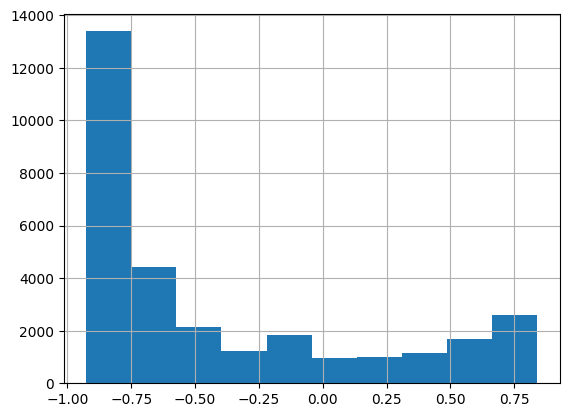

In [226]:
tw_df['position_scores'].hist()

In [227]:
tw_df.to_csv('data/py_outputs/tw_scaled_positions.csv', encoding='utf-8',index=False)

# Doc2Vec scaling

In [180]:
pca = PCA(n_components=2)

In [276]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8', dtype={'cmp_code':'str', 'is_copy_of':'str'})


In [280]:
manifesto_deu = manifesto[manifesto.countryname=='Germany'].reset_index(drop=True)
manifesto_deu.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,country,party_code,countryname,abbrev,name,edate,parfam,sentiment,topic,election
0,Es ist Zeit für einen Wechsel,It's time for a change,000,NaN,26,41113_199809,41113,199809,german,MARPOR,...,41,41113,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,neutral,Other,1998
1,"Die Bundesrepublik braucht eine neue, eine soz...","Germany needs a new, social and ecological policy",303,NaN,27,41113_199809,41113,199809,german,MARPOR,...,41,41113,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,neutral,Other,1998
2,Die Herausforderungen eines neuen Jahrhunderts...,The challenges of a new century cannot be mast...,303,NaN,28,41113_199809,41113,199809,german,MARPOR,...,41,41113,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,neutral,Other,1998
3,Politik kann nicht alle Probleme lösen,Politics cannot solve all problems,000,NaN,29,41113_199809,41113,199809,german,MARPOR,...,41,41113,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,neutral,Other,1998
4,Aber Politik muß ihren Teil zur Lösung der Pro...,But politics must play its part in solving the...,000,NaN,30,41113_199809,41113,199809,german,MARPOR,...,41,41113,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,neutral,Other,1998


In [284]:
outputs = []
for idx, text in enumerate(manifesto_deu['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_deu.loc[idx,'countryname'].lower()
    if country in ['france','belgium']:
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country in ['germany','austria', 'switzerland']:
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    elif country == 'denmark':
        outputs.append(clean_text(text, stopwords.words('danish')))
    elif country == 'portugal':
        outputs.append(clean_text(text, stopwords.words('portuguese')))
    elif country == 'netherlands':
        outputs.append(clean_text(text, stopwords.words('dutch')))
    elif country == 'norway':
        outputs.append(clean_text(text, stopwords.words('norwegian')))
    elif country == 'sweden':
        outputs.append(clean_text(text, stopwords.words('swedish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 0th sentence
Cleaning the 10000th sentence
Cleaning the 20000th sentence
Cleaning the 30000th sentence
Cleaning the 40000th sentence
Cleaning the 50000th sentence
Cleaning the 60000th sentence
Cleaning the 70000th sentence
Cleaning the 80000th sentence


In [285]:
manifesto_deu['text_cleaned'] = outputs

In [286]:
manifesto_deu.loc[:,'party_election'] = manifesto_deu.party.astype(str).str.cat(manifesto_deu.election.astype(str), sep='_')

In [187]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram: 
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        print('Starting new epoch')
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

## Doc2Vec scaling - original approach by R&C - Germany general

In [188]:
manifesto_deu.groupby(['topic']).count()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,party_code,countryname,abbrev,name,edate,parfam,sentiment,election,text_cleaned,party_election
topic,,,,,,,,,,,,,,,,,,,,,
Agriculture - Protectionism,1094,1094,1094,11,1094,1094,1094,1094,1094,1094,...,1094,1094,1086,1094,1094,1094,1094,1094,1094,1094
Civil Rights,7892,7892,7892,4,7892,7892,7892,7892,7892,7892,...,7892,7892,7797,7892,7892,7892,7892,7892,7892,7892
Decentralization,3043,3043,3043,6,3043,3043,3043,3043,3043,3043,...,3043,3043,3036,3043,3043,3043,3043,3043,3043,3043
Economics,10011,10011,10011,56,10011,10011,10011,10011,10011,10011,...,10011,10011,9835,10011,10011,10011,10011,10011,10011,10011
Education,3152,3152,3152,0,3152,3152,3152,3152,3152,3152,...,3152,3152,3059,3152,3152,3152,3152,3152,3152,3152
Environment - Growth,7343,7343,7343,29,7343,7343,7343,7343,7343,7343,...,7343,7343,7209,7343,7343,7343,7343,7343,7343,7343
European Integration,2419,2419,2419,1,2419,2419,2419,2419,2419,2419,...,2419,2419,2399,2419,2419,2419,2419,2419,2419,2419
Immigration,2706,2706,2706,5,2706,2706,2706,2706,2706,2706,...,2706,2706,2669,2706,2706,2706,2706,2706,2706,2706
International Relations,3867,3867,3867,4,3867,3867,3867,3867,3867,3867,...,3867,3867,3847,3867,3867,3867,3867,3867,3867,3867


In [189]:
outputs_stream = phraseIterator(manifesto_deu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [190]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [191]:
model.train(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [192]:
embed_dict = d2v_reduct(model)

In [193]:
df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
df_d2v.index.name = 'party_election'
df_d2v.reset_index(inplace=True)

In [194]:
pca = PCA(n_components=2, random_state=seed_val)

In [195]:
df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:,1:])
df_d2v = df_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [196]:
df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
df_d2v.loc[:,'election'] = df_d2v['election'].astype(int)
df_d2v.loc[:,'party_name'] = df_d2v['party'].astype(str).apply(party_deu)
df_d2v = df_d2v[df_d2v.party_name!='Other']

In [197]:
df_d2v

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-3.320543,13.799252,41113,1998,Alliance 90/Greens
1,41221_1998,-4.707960,14.302328,41221,1998,The Left
2,41320_1998,-3.258560,-13.197150,41320,1998,SPD
3,41420_1998,18.942930,1.441194,41420,1998,FDP
4,41521_1998,7.009283,-13.508457,41521,1998,CDU/CSU
5,41113_2002,-6.857506,-0.771311,41113,2002,Alliance 90/Greens
6,41221_2002,-6.648407,2.072216,41221,2002,The Left
7,41320_2002,-0.061402,-15.209155,41320,2002,SPD
8,41420_2002,20.111597,3.334245,41420,2002,FDP
9,41521_2002,13.128374,-13.629312,41521,2002,CDU/CSU


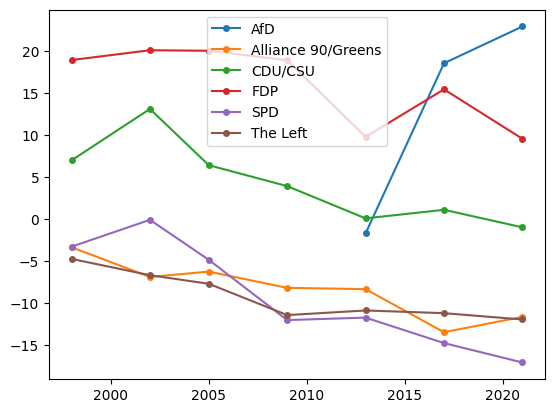

In [198]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df_d2v.groupby('party_name'):
    ax.plot(group.election, group.d2v_d1, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [199]:
df_d2v.to_csv('data/py_outputs/r&c_gen.csv', index=False)

## Doc2Vec scaling - Germany, environment
 

In [203]:
manifesto_deu_env = manifesto_deu[manifesto_deu.topic == 'Environment - Growth'].reset_index(drop=True)


In [204]:
manifesto_deu_env.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Sie haben die Wahl zwischen dem Erhalt unserer...,You have the choice between preserving our nat...,416.0,NaN,33,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,wahl erhalt unserer natürlichen lebensgrundlag...,41113_1998
1,"BÜNDNIS 90/DIE GRÜNEN stehen für Nachhaltigkeit,","Alliance 90/The Greens stand for sustainability,",416.0,NaN,36,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,bündnis grünen stehen nachhaltigkeit,41113_1998
2,Wir wollen die Bundesrepublik ökologisch moder...,We want to modernize the Federal Republic ecol...,416.0,NaN,40,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,bundesrepublik ökologisch modernisieren,41113_1998
3,Tatsächlich hat die Bundesrepublik von der Glo...,Germany has indeed benefited from globalization,410.0,NaN,60,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Environment - Growth,1998,tatsächlich bundesrepublik globalisierung prof...,41113_1998
4,Sie wurde Exportvizeweltmeister,She became export vice world champion,410.0,NaN,61,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Environment - Growth,1998,wurde exportvizeweltmeister,41113_1998


In [205]:
outputs_stream = phraseIterator(manifesto_deu_env,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [206]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_env, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [207]:
model.train(corpusIterator(manifesto_deu_env, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [208]:
embed_dict = d2v_reduct(model)

In [209]:
d2v_env = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_env.index.name = 'party_election'
d2v_env.reset_index(inplace=True)

In [210]:
d2v_env[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_env.iloc[:,1:])

In [211]:
d2v_env = d2v_env[['party_election','d2v_d1', 'd2v_d2']]

In [212]:
d2v_env[['party', 'election']] = d2v_env['party_election'].str.split('_', expand=True)
d2v_env.loc[:,'election'] = d2v_env['election'].astype(int)
d2v_env.loc[:,'party_name'] = d2v_env['party'].astype(str).apply(party_deu)
d2v_env = d2v_env[d2v_env.party_name!='Other']

In [213]:
d2v_env

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-4.163558,0.390604,41113,1998,Alliance 90/Greens
1,41221_1998,-0.820114,0.043626,41221,1998,The Left
2,41320_1998,1.785581,-0.020713,41320,1998,SPD
3,41420_1998,-2.042185,0.061769,41420,1998,FDP
4,41521_1998,2.682924,-0.018520,41521,1998,CDU/CSU
5,41113_2002,-3.185717,0.345561,41113,2002,Alliance 90/Greens
6,41221_2002,6.440806,-0.028944,41221,2002,The Left
7,41320_2002,5.273668,-0.028003,41320,2002,SPD
8,41420_2002,2.737943,-0.003253,41420,2002,FDP
9,41521_2002,1.861760,0.019100,41521,2002,CDU/CSU


In [214]:
d2v_env.to_csv('data/py_outputs/r&c_env.csv', index=False)

## Doc2Vec scaling - Germany, decentralization    
 

In [215]:
manifesto_deu_regions = manifesto_deu[manifesto_deu.topic == 'Decentralization'].reset_index(drop=True)


In [216]:
outputs_stream = phraseIterator(manifesto_deu_regions,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [217]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_regions, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [218]:
model.train(corpusIterator(manifesto_deu_regions, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [219]:
embed_dict = d2v_reduct(model)

In [220]:
d2v_regions = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_regions.index.name = 'party_election'
d2v_regions.reset_index(inplace=True)

In [221]:
d2v_regions[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_regions.iloc[:,1:])

In [222]:
d2v_regions = d2v_regions[['party_election','d2v_d1', 'd2v_d2']]
d2v_regions[['party', 'election']] = d2v_regions['party_election'].str.split('_', expand=True)
d2v_regions.loc[:,'election'] = d2v_regions['election'].astype(int)
d2v_regions.loc[:,'party_name'] = d2v_regions['party'].astype(str).apply(party_deu)
d2v_regions = d2v_regions[d2v_regions.party_name!='Other']

In [223]:
d2v_regions

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-0.244209,-0.025007,41113,1998,Alliance 90/Greens
1,41221_1998,0.481165,-0.047768,41221,1998,The Left
2,41320_1998,6.289295,-0.065807,41320,1998,SPD
3,41420_1998,0.516570,0.043324,41420,1998,FDP
4,41521_1998,2.831372,0.018533,41521,1998,CDU/CSU
5,41113_2002,-1.106795,-0.003250,41113,2002,Alliance 90/Greens
6,41221_2002,-0.866970,-0.011451,41221,2002,The Left
7,41320_2002,-1.063675,0.083662,41320,2002,SPD
8,41420_2002,-2.973428,0.102648,41420,2002,FDP
9,41521_2002,-3.310353,-0.000806,41521,2002,CDU/CSU


In [224]:
d2v_regions.to_csv('data/py_outputs/r&c_regions.csv', index=False)

## Doc2Vec scaling - Germany, economy
 

In [225]:
manifesto_deu_econ = manifesto_deu[manifesto_deu.topic == 'Economics'].reset_index(drop=True)


In [226]:
manifesto_deu_econ.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Auf der Einnahmeseite stehen: ? Einführung ein...,On the revenue side: ? introduction of an ener...,403.0,NaN,178,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Economics,1998,einnahmeseite stehen einführung energiesteuer,41113_1998
1,? Erhöhung der Mineralölsteuer und Einführung ...,? Increase in mineral oil tax and introduction...,403.0,NaN,179,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Economics,1998,erhöhung mineralölsteuer einführung schwerverk...,41113_1998
2,Mögliche Überschüsse wollen wir den Bürgerinne...,We want to give any surpluses back to the citi...,401.0,NaN,184,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Economics,1998,mögliche überschüsse bürgerinnen bürgern zurüc...,41113_1998
3,Das gesamte Konzept ist zunächst auf 10 Jahre ...,The entire concept is initially designed to ru...,404.0,NaN,191,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Economics,1998,gesamte konzept zunächst jahre angelegt,41113_1998
4,Für energieintensive Branchen wollen wir in di...,We want to grant adjustment aid for energy-int...,402.0,NaN,192,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Economics,1998,energieintensive branchen zeitraum anpassungsh...,41113_1998


In [227]:
outputs_stream = phraseIterator(manifesto_deu_econ,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [228]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_econ, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [229]:
model.train(corpusIterator(manifesto_deu_econ, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [230]:
embed_dict = d2v_reduct(model)

In [231]:
d2v_econ = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_econ.index.name = 'party_election'
d2v_econ.reset_index(inplace=True)

In [232]:
d2v_econ[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_econ.iloc[:,1:])

In [233]:
d2v_econ = d2v_econ[['party_election','d2v_d1', 'd2v_d2']]
d2v_econ[['party', 'election']] = d2v_econ['party_election'].str.split('_', expand=True)
d2v_econ.loc[:,'election'] = d2v_econ['election'].astype(int)
d2v_econ.loc[:,'party_name'] = d2v_econ['party'].astype(str).apply(party_deu)
d2v_econ = d2v_econ[d2v_econ.party_name!='Other']

In [234]:
d2v_econ

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-0.822871,0.148774,41113,1998,Alliance 90/Greens
1,41221_1998,3.590781,0.070648,41221,1998,The Left
2,41320_1998,1.419270,-0.280430,41320,1998,SPD
3,41420_1998,-1.798891,-0.731326,41420,1998,FDP
4,41521_1998,3.984235,-0.277378,41521,1998,CDU/CSU
5,41113_2002,1.827731,-0.154709,41113,2002,Alliance 90/Greens
6,41221_2002,2.132005,0.020509,41221,2002,The Left
7,41320_2002,0.795607,-0.355715,41320,2002,SPD
8,41420_2002,-2.002684,-1.324112,41420,2002,FDP
9,41521_2002,-1.242557,-0.824858,41521,2002,CDU/CSU


In [235]:
d2v_econ.to_csv('data/py_outputs/r&c_econ.csv', index=False)

## Doc2Vec scaling - Germany, EU Integration
 

In [236]:
manifesto_deu_eu = manifesto_deu[manifesto_deu.topic == 'European Integration'].reset_index(drop=True)


In [237]:
manifesto_deu_eu.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Mehr Demokratie und demokratische Kontrolle fo...,We demand more democracy and democratic contro...,110.0,NaN,1693,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,European Integration,1998,mehr demokratie demokratische kontrolle forder...,41113_1998
1,Es darf keine Ausweitung der Kompetenzen europ...,There must be no extension of the competences ...,110.0,NaN,1694,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,European Integration,1998,darf ausweitung kompetenzen europäischer einri...,41113_1998
2,Die Abschottung der europäischen Grenzen und d...,We reject the sealing off of European borders ...,110.0,NaN,1783,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,European Integration,1998,abschottung europäischen grenzen elektronische...,41113_1998
3,Auf dem Weg von Bonn nach Brüssel darf die Dem...,"However, democracy must not fall by the waysid...",110.0,NaN,2109,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,European Integration,1998,bonn brüssel darf demokratie strecke bleiben,41113_1998
4,Gemessen an den Notwendigkeiten einer demokrat...,Measured against the necessities of democratic...,110.0,NaN,2152,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,European Integration,1998,gemessen notwendigkeiten demokratischen politi...,41113_1998


In [238]:
outputs_stream = phraseIterator(manifesto_deu_eu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [239]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_eu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [240]:
model.train(corpusIterator(manifesto_deu_eu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [241]:
embed_dict = d2v_reduct(model)

In [242]:
d2v_eu = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_eu.index.name = 'party_election'
d2v_eu.reset_index(inplace=True)

In [243]:
d2v_eu[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_eu.iloc[:,1:])

In [244]:
d2v_eu = d2v_eu[['party_election','d2v_d1', 'd2v_d2']]
d2v_eu[['party', 'election']] = d2v_eu['party_election'].str.split('_', expand=True)
d2v_eu.loc[:,'election'] = d2v_eu['election'].astype(int)
d2v_eu.loc[:,'party_name'] = d2v_eu['party'].astype(str).apply(party_deu)
d2v_eu = d2v_eu[d2v_eu.party_name!='Other']

In [245]:
d2v_eu

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,6.739961,-0.002458,41113,1998,Alliance 90/Greens
1,41221_1998,11.061740,-0.008238,41221,1998,The Left
2,41420_1998,3.871808,0.002279,41420,1998,FDP
3,41113_2002,2.944809,-0.005513,41113,2002,Alliance 90/Greens
4,41221_2002,5.022391,0.000581,41221,2002,The Left
5,41320_2002,1.063000,0.003821,41320,2002,SPD
6,41420_2002,-2.323716,0.000353,41420,2002,FDP
7,41521_2002,3.146336,-0.003831,41521,2002,CDU/CSU
8,41113_2005,-1.558559,-0.003312,41113,2005,Alliance 90/Greens
9,41222_2005,3.168749,-0.000797,41222,2005,The Left


In [246]:
d2v_eu.to_csv('data/py_outputs/r&c_eu.csv', index=False)

## Doc2Vec scaling - Germany, welfare
 

In [247]:
manifesto_deu_wf = manifesto_deu[manifesto_deu.topic == 'Labour and Social Welfare'].reset_index(drop=True)


In [248]:
manifesto_deu_wf.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,"soziale Gerechtigkeit,","social justice,",503.0,NaN,37,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Labour and Social Welfare,1998,soziale gerechtigkeit,41113_1998
1,und Gleichberechtigung der Frauen,and equal rights for women,503.0,NaN,39,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Labour and Social Welfare,1998,gleichberechtigung frauen,41113_1998
2,Wir wollen die Erwerbslosigkeit aktiv bekämpfen,We want to actively combat unemployment,701.0,NaN,41,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Labour and Social Welfare,1998,erwerbslosigkeit aktiv bekämpfen,41113_1998
3,Wir wollen den Sozialstaat durch Erneuerung si...,We want to secure the welfare state through re...,504.0,NaN,42,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Labour and Social Welfare,1998,sozialstaat erneuerung sichern,41113_1998
4,Soziale Unsicherheit ist allgemein geworden,Social insecurity has become generalized,503.0,NaN,52,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Labour and Social Welfare,1998,soziale unsicherheit allgemein geworden,41113_1998


In [249]:
outputs_stream = phraseIterator(manifesto_deu_wf,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [250]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_wf, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [251]:
model.train(corpusIterator(manifesto_deu_wf, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [252]:
embed_dict = d2v_reduct(model)

In [253]:
d2v_wf = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_wf.index.name = 'party_election'
d2v_wf.reset_index(inplace=True)

In [254]:
d2v_wf[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_wf.iloc[:,1:])

In [255]:
d2v_wf = d2v_wf[['party_election','d2v_d1', 'd2v_d2']]
d2v_wf[['party', 'election']] = d2v_wf['party_election'].str.split('_', expand=True)
d2v_wf.loc[:,'election'] = d2v_wf['election'].astype(int)
d2v_wf.loc[:,'party_name'] = d2v_wf['party'].astype(str).apply(party_deu)
d2v_wf = d2v_wf[d2v_wf.party_name!='Other']

In [256]:
d2v_wf

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-1.566673,-3.860194,41113,1998,Alliance 90/Greens
1,41221_1998,1.401857,-4.938044,41221,1998,The Left
2,41320_1998,-4.047880,-4.185433,41320,1998,SPD
3,41420_1998,-2.044656,-3.976614,41420,1998,FDP
4,41521_1998,-0.939228,-1.628499,41521,1998,CDU/CSU
5,41113_2002,-3.681797,-0.466138,41113,2002,Alliance 90/Greens
6,41221_2002,0.863570,-2.917659,41221,2002,The Left
7,41320_2002,-3.128446,-1.832919,41320,2002,SPD
8,41420_2002,-2.350208,-2.364601,41420,2002,FDP
9,41521_2002,-2.395751,-1.359024,41521,2002,CDU/CSU


In [257]:
d2v_wf.to_csv('data/py_outputs/r&c_wf.csv', index=False)

## Doc2Vec scaling - Germany, Immigration
 

In [258]:
manifesto_deu_imm = manifesto_deu[manifesto_deu.topic == 'Immigration'].reset_index(drop=True)


In [259]:
manifesto_deu_imm.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Wir stellen uns der Verantwortung für die deut...,We face up to our responsibility for German hi...,602.0,NaN,1714,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Immigration,1998,stellen verantwortung deutsche geschichte,41113_1998
1,"Wir setzen uns für die volle Anerkennung, rech...","We are committed to the full recognition, lega...",602.0,NaN,1715,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Immigration,1998,setzen volle anerkennung rechtliche rehabiliti...,41113_1998
2,Wir wollen ein umfassendes Rehabilitierungsges...,We want a comprehensive rehabilitation law and...,602.0,NaN,1716,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Immigration,1998,umfassendes rehabilitierungsgesetz errichtung ...,41113_1998
3,Erinnerungs- und Dokumentationsarbeit ist auch...,Remembrance and documentation work must also b...,602.0,NaN,1718,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Immigration,1998,erinnerungs dokumentationsarbeit vergessenen o...,41113_1998
4,Das Bundesarchivgesetz darf nicht weiterhin di...,The Federal Archives Act must not continue to ...,602.0,NaN,1719,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Immigration,1998,bundesarchivgesetz darf weiterhin geschichtlic...,41113_1998


In [260]:
outputs_stream = phraseIterator(manifesto_deu_imm,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [261]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_imm, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [262]:
model.train(corpusIterator(manifesto_deu_imm, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [263]:
embed_dict = d2v_reduct(model)

In [264]:
d2v_imm = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_imm.index.name = 'party_election'
d2v_imm.reset_index(inplace=True)

In [265]:
d2v_imm[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_imm.iloc[:,1:])

In [266]:
d2v_imm = d2v_imm[['party_election','d2v_d1', 'd2v_d2']]
d2v_imm[['party', 'election']] = d2v_imm['party_election'].str.split('_', expand=True)
d2v_imm.loc[:,'election'] = d2v_imm['election'].astype(int)
d2v_imm.loc[:,'party_name'] = d2v_imm['party'].astype(str).apply(party_deu)
d2v_imm = d2v_imm[d2v_imm.party_name!='Other']

In [267]:
d2v_imm

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,2.229218,0.012244,41113,1998,Alliance 90/Greens
1,41221_1998,4.675115,0.015845,41221,1998,The Left
2,41320_1998,5.831944,0.010267,41320,1998,SPD
3,41420_1998,-0.364329,0.004980,41420,1998,FDP
4,41521_1998,-0.613653,0.010624,41521,1998,CDU/CSU
5,41113_2002,4.470844,0.006764,41113,2002,Alliance 90/Greens
6,41221_2002,5.963728,0.015340,41221,2002,The Left
7,41320_2002,2.161376,0.007257,41320,2002,SPD
8,41420_2002,-1.103819,0.011532,41420,2002,FDP
9,41521_2002,-3.413524,0.043323,41521,2002,CDU/CSU


In [268]:
d2v_imm.to_csv('data/py_outputs/r&c_imm.csv', index=False)

## Doc2Vec scaling - Germany, environment protection
 

In [289]:
manifesto_deu_ep = manifesto_deu[manifesto_deu.cmp_code.isin(['501'])].reset_index(drop=True)


In [290]:
manifesto_deu_ep.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Deutschland belastet die Erdatmosphäre durch k...,Germany pollutes the Earth's atmosphere with c...,501,NaN,66,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,deutschland belastet erdatmosphäre klimaschädl...,41113_1998
1,Die Bundesregierung fördert den Auto- und Flug...,The German government promotes car and air tra...,501,NaN,67,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,bundesregierung fördert auto flugverkehr hohe ...,41113_1998
2,Längst sind die Auswirkungen lokaler Umweltdes...,effects of local environmental disasters have ...,501,NaN,159,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,längst auswirkungen lokaler umweltdesaster glo...,41113_1998
3,Umweltschutz steht heute nicht im Mittelpunkt ...,Environmental protection is not the focus of p...,501,NaN,161,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,umweltschutz steht heute mittelpunkt öffentlic...,41113_1998
4,Längst sicher geglaubte Errungenschaften der U...,Achievements of the environmental movement tha...,501,NaN,162,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,längst sicher geglaubte errungenschaften umwel...,41113_1998


In [291]:
outputs_stream = phraseIterator(manifesto_deu_ep,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [292]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_ep, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [293]:
model.train(corpusIterator(manifesto_deu_ep, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [294]:
embed_dict = d2v_reduct(model)

In [295]:
d2v_ep = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_ep.index.name = 'party_election'
d2v_ep.reset_index(inplace=True)

In [296]:
d2v_ep[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_ep.iloc[:,1:])

In [297]:
d2v_ep = d2v_ep[['party_election','d2v_d1', 'd2v_d2']]
d2v_ep[['party', 'election']] = d2v_ep['party_election'].str.split('_', expand=True)
d2v_ep.loc[:,'election'] = d2v_ep['election'].astype(int)
d2v_ep.loc[:,'party_name'] = d2v_ep['party'].astype(str).apply(party_deu)
d2v_ep = d2v_ep[d2v_ep.party_name!='Other']

In [298]:
d2v_ep

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-2.726533,-0.080976,41113,1998,Alliance 90/Greens
1,41221_1998,4.638536,0.018551,41221,1998,The Left
2,41320_1998,5.820209,0.009352,41320,1998,SPD
3,41420_1998,-1.300148,-0.024202,41420,1998,FDP
4,41521_1998,8.746316,0.027031,41521,1998,CDU/CSU
5,41113_2002,-3.506371,-0.096274,41113,2002,Alliance 90/Greens
6,41221_2002,8.383902,0.032204,41221,2002,The Left
7,41320_2002,7.592631,0.026799,41320,2002,SPD
8,41420_2002,2.477205,-0.016905,41420,2002,FDP
9,41521_2002,1.544838,-0.012058,41521,2002,CDU/CSU


In [299]:
d2v_ep.to_csv('data/py_outputs/r&c_ep.csv', index=False)

## Doc2Vec scaling - Germany, growth vs anti growth
 

In [301]:
manifesto_deu_growth = manifesto_deu[manifesto_deu.cmp_code.isin(['410','416', '416.1','416.2'])].reset_index(drop=True)


In [302]:
manifesto_deu_growth.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,countryname,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election
0,Sie haben die Wahl zwischen dem Erhalt unserer...,You have the choice between preserving our nat...,416,NaN,33,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,wahl erhalt unserer natürlichen lebensgrundlag...,41113_1998
1,"BÜNDNIS 90/DIE GRÜNEN stehen für Nachhaltigkeit,","Alliance 90/The Greens stand for sustainability,",416,NaN,36,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,bündnis grünen stehen nachhaltigkeit,41113_1998
2,Wir wollen die Bundesrepublik ökologisch moder...,We want to modernize the Federal Republic ecol...,416,NaN,40,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,left,Environment - Growth,1998,bundesrepublik ökologisch modernisieren,41113_1998
3,Tatsächlich hat die Bundesrepublik von der Glo...,Germany has indeed benefited from globalization,410,NaN,60,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Environment - Growth,1998,tatsächlich bundesrepublik globalisierung prof...,41113_1998
4,Sie wurde Exportvizeweltmeister,She became export vice world champion,410,NaN,61,41113_199809,41113,199809,german,MARPOR,...,Germany,90/Greens,Bündnis‘90/Die Grünen,27/09/1998,10,right,Environment - Growth,1998,wurde exportvizeweltmeister,41113_1998


In [303]:
outputs_stream = phraseIterator(manifesto_deu_growth,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [304]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_growth, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


Starting new epoch


In [305]:
model.train(corpusIterator(manifesto_deu_growth, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=20)

Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch


In [306]:
embed_dict = d2v_reduct(model)

In [307]:
d2v_growth = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_growth.index.name = 'party_election'
d2v_growth.reset_index(inplace=True)

In [308]:
d2v_growth[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_growth.iloc[:,1:])

In [309]:
d2v_growth = d2v_growth[['party_election','d2v_d1', 'd2v_d2']]
d2v_growth[['party', 'election']] = d2v_growth['party_election'].str.split('_', expand=True)
d2v_growth.loc[:,'election'] = d2v_growth['election'].astype(int)
d2v_growth.loc[:,'party_name'] = d2v_growth['party'].astype(str).apply(party_deu)
d2v_growth = d2v_growth[d2v_growth.party_name!='Other']

In [310]:
d2v_growth

,party_election,d2v_d1,d2v_d2,party,election,party_name
0,41113_1998,-7.588250,-0.194705,41113,1998,Alliance 90/Greens
1,41221_1998,-2.043898,-0.048610,41221,1998,The Left
2,41320_1998,-0.404105,-0.032293,41320,1998,SPD
3,41420_1998,-0.938941,-0.018950,41420,1998,FDP
4,41521_1998,0.056920,-0.017087,41521,1998,CDU/CSU
5,41113_2002,-4.407357,-0.069928,41113,2002,Alliance 90/Greens
6,41221_2002,5.351589,0.012014,41221,2002,The Left
7,41320_2002,3.969707,0.012389,41320,2002,SPD
8,41420_2002,6.520084,0.025462,41420,2002,FDP
9,41521_2002,5.838186,0.018788,41521,2002,CDU/CSU


In [311]:
d2v_growth.to_csv('data/py_outputs/r&c_growth.csv', index=False)

# Scale position scores for all countries (released dataset + model)

## Retrain for the entire dataset with all languages

In [4]:
manifesto_org = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8", dtype={2:'str',18:'str'})

In [5]:
manifesto_other = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8", dtype={2:'str',18:'str'})

In [6]:
manifesto_org_cleaned = manifesto_org.dropna(axis=1, how='all')
manifesto_other_cleaned = manifesto_other.dropna(axis=1, how='all')
manifesto_full = pd.concat([manifesto_org_cleaned, manifesto_other_cleaned]).reset_index(drop=True)

In [9]:
manifesto_full.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,title,translation_en,id,country,party_code,countryname,abbrev,name,edate,parfam
0,Miljöpartiet de Gröna går till val på en polit...,The Green Party is running on a policy for mor...,408,NaN,1,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
1,"fler företag,","more businesses, a",402,NaN,2,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
2,"levande landsbygd,","vibrant countryside,",301,NaN,3,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
3,nya livschanser,new life chances,504,NaN,4,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
4,och ett långsiktigt miljöansvar.,and long-term environmental responsibility.,501,NaN,5,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0


In [10]:
len(manifesto_full)

1030129

In [7]:
manifesto_full = manifesto_full[(manifesto_full.cmp_code.notna()) & ~(manifesto_full.cmp_code == 'H')].reset_index(drop=True)

In [8]:
manifesto_full['sentiment'] = manifesto_full['cmp_code'].apply(sentiment_code)
manifesto_full['topic'] = manifesto_full['cmp_code'].apply(topic_code)
manifesto_full['election'] = manifesto_full['date'].astype(str).str[:4]

In [9]:
manifesto_full.groupby('sentiment').count()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,id,country,party_code,countryname,abbrev,name,edate,parfam,topic,election
sentiment,,,,,,,,,,,,,,,,,,,,,
left,523785,464380,523785,497,523785,523785,523785,523785,523785,483705,...,483705,523785,523785,519994,490380,519994,519994,519994,523785,523785
neutral,245997,208066,245997,202,245997,245997,245997,245997,245997,216737,...,216737,245997,245997,244783,231698,244783,244783,244783,245997,245997
right,205496,175872,205496,462,205496,205496,205496,205496,205496,182881,...,182881,205496,205496,204199,196171,204199,204199,204199,205496,205496


In [10]:
manifesto_full.groupby(['topic'])['sentiment'].value_counts().unstack(fill_value=0)

sentiment,left,neutral,right
topic,,,
Agriculture - Protectionism,22929,0,2506
Civil Rights,39173,0,57744
Decentralization,2375,0,37681
Economics,58507,0,44805
Education,49656,0,662
Environment - Growth,89054,0,14133
European Integration,14662,0,6240
Immigration,12906,0,20398
International Relations,31017,0,2441


In [11]:
results = group_texts(manifesto_full, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [12]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [13]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [14]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'cmp_code']

In [15]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105


In [16]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)
 

In [17]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code,sentiment,topic
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104,right,Military
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105,left,Military
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military


In [18]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped_full_processed.csv', encoding='utf-8', index=False)
manifesto_full.to_csv('data/temps/manifesto_full_processed.csv', encoding='utf-8', index=False)

In [19]:
manifesto_reduced = manifesto_regrouped[['topic','sentiment','text']].reset_index(drop=True)

In [20]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [21]:
manifesto_reduced.loc[:,'topic_sentiment'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['sentiment']

In [22]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_sentiment')



Casting to class labels:   0%|          | 0/369755 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/369755 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/369755 [00:00<?, ? examples/s]

In [23]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_sentiment', seed=seed_val)

In [24]:
manifesto_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 332779
    })
    test: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 36976
    })
})

In [26]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

Map:   0%|          | 0/332779 [00:00<?, ? examples/s]

Map:   0%|          | 0/36976 [00:00<?, ? examples/s]

{'train': ['topic', 'sentiment', 'input_ids', 'attention_mask'],
 'test': ['topic', 'sentiment', 'input_ids', 'attention_mask']}

In [27]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn = data_collator)


In [28]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)



In [29]:
model.get_trainable_params(return_count=True)

18657954

In [30]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sentiment = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [31]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sentiment, criterion_topic, sentiment_var='sentiment',
               topic_var='topic')

Epoch: 1

Training...
loss: 2.007146  [ 1600/332779].
Elapsed time: 0:00:23, Estimated remaining time: 1:20:14
loss: 1.896940  [ 3200/332779].
Elapsed time: 0:00:45, Estimated remaining time: 1:17:08
loss: 1.831144  [ 4800/332779].
Elapsed time: 0:01:07, Estimated remaining time: 1:15:47
loss: 1.797617  [ 6400/332779].
Elapsed time: 0:01:28, Estimated remaining time: 1:14:24
loss: 1.777622  [ 8000/332779].
Elapsed time: 0:01:50, Estimated remaining time: 1:14:11
loss: 1.767225  [ 9600/332779].
Elapsed time: 0:02:10, Estimated remaining time: 1:12:59
loss: 1.760409  [11200/332779].
Elapsed time: 0:02:32, Estimated remaining time: 1:12:30
loss: 1.753931  [12800/332779].
Elapsed time: 0:02:52, Estimated remaining time: 1:11:44
loss: 1.746853  [14400/332779].
Elapsed time: 0:03:12, Estimated remaining time: 1:10:53
loss: 1.738998  [16000/332779].
Elapsed time: 0:03:33, Estimated remaining time: 1:10:18
loss: 1.715756  [17600/332779].
Elapsed time: 0:03:54, Estimated remaining time: 1:09:51

In [32]:
state_dict = model.state_dict()
save_file(state_dict, 'results/multilingual/manifesto_full_released/model.safetensors')

In [33]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = TIPredictWithDualAttention(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=True).to(device)

model=None

In [34]:
loaded_tensors = load_file('results/multilingual/manifesto_full_released/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [35]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 300}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/369755 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [36]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn= data_collator)

In [37]:
## Compute position scores
position_scores, pred_topics, pred_sentiment = scale_func(pred_dataloader, scaling_model, device, topic_label='topic')

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 0:00:49, Estimated remaining time: 0:37:00
Elapsed time: 0:01:56, Estimated remaining time: 0:42:53
Elapsed time: 0:03:12, Estimated remaining time: 0:46:12
Elapsed time: 0:04:26, Estimated remaining time: 0:46:45
Elapsed time: 0:05:39, Estimated remaining time: 0:46:32
Elapsed time: 0:06:52, Estimated remaining time: 0:46:00
Elapsed time: 0:08:14, Estimated remaining time: 0:46:08
Elapsed time: 0:09:18, Estimated remaining time: 0:44:26
Elapsed time: 0:10:34, Estimated remaining time: 0:43:42
Elapsed time: 0:11:44, Estimated remaining time: 0:42:32
Elapsed time: 0:12:40, Estimated remaining time: 0:40:33
Elapsed time: 0:13:34, Estimated remaining time: 0:38:43
Elapsed time: 0:14:36, Estimated remaining time: 0:37:20
Elapsed time: 0:15:36, Estimated remaining time: 0:35:54
Elapsed time: 0:16:33, Estimated remaining time: 0:34:27
Elapsed time: 0:17:33, Estimated remaining time

In [39]:
list_names = manifesto_dataset.features['sentiment'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [41]:
manifesto_regrouped.loc[:,'position_scores'] = position_scores.flatten()
manifesto_regrouped.loc[:,'pred_sentiment'] = pred_sentiment
manifesto_regrouped.loc[:,'pred_sentiment_name'] = manifesto_regrouped.pred_sentiment.map(name_topic_dict)

In [42]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code,sentiment,topic,position_scores,pred_sentiment,pred_sentiment_name
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104,right,Military,-0.124553,0,left
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105,left,Military,-0.734052,0,left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military,0.167152,2,right
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military,-0.612818,0,left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military,-0.642345,0,left


In [43]:
manifesto_regrouped.to_csv('results/datasets/manifesto_regrouped_full_scaled.csv', encoding='utf-8')

## Check accuracy

In [35]:
labels = manifesto_dataset['sentiment']
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_sentiment, average=None)
matrix = confusion_matrix(labels, pred_sentiment)
accuracy = matrix.diagonal()/matrix.sum(axis=1)


In [36]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.98,0.98,0.98,0.98
1,0.99,0.99,0.99,0.99
2,0.93,0.94,0.92,0.92


In [37]:
round(res_table.mean(axis=0),2)

f1           0.97
precision    0.97
recall       0.96
accuracy     0.96
dtype: float64

In [38]:
list_names = manifesto_dataset.features['lrn'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])
name_topic_dict

{0: 'left', 1: 'neutral', 2: 'right'}

In [39]:
res_table['lrn'] = pd.Series(res_table.index.values).map(name_topic_dict)
res_table

,f1,precision,recall,accuracy,lrn
0,0.98,0.98,0.98,0.98,left
1,0.99,0.99,0.99,0.99,neutral
2,0.93,0.94,0.92,0.92,right


## Create released dataset (position scores by country-party-election)

In [49]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,code_long,code_extract,lrn,topic,country_party_election,party_group,position_scores,pred_lrn_index,pred_lrn
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria_1999_42110_10400,Austria,1999,42110,10400,104,right,Defense,Austria_42110_1999,Left,-0.688701,0,left
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left,-0.999584,0,left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left,-0.654904,0,left
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left,-0.996715,0,left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria_1999_42110_10500,Austria,1999,42110,10500,105,left,Defense,Austria_42110_1999,Left,-0.999724,0,left


In [50]:
columns  =['country','party', 'election','topic','cs_mean_score', 'cs_se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_regrouped.groupby(['country','party','election','topic']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                             str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
                    str(group.iloc[0,group.columns.get_loc('topic')]),
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8922 entries, 0 to 8921
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        8922 non-null   object 
 1   party          8922 non-null   object 
 2   election       8922 non-null   object 
 3   topic          8922 non-null   object 
 4   cs_mean_score  8922 non-null   float64
 5   cs_se_score    8138 non-null   float64
dtypes: float64(2), object(4)
memory usage: 418.3+ KB


In [52]:
df.head()

,country,party,election,topic,cs_mean_score,cs_se_score
0,Austria,42110,1999,Agriculture,0.099999,NaN
1,Austria,42110,1999,Civil Rights,-0.516919,0.079433
2,Austria,42110,1999,Decentralization,0.933253,0.066609
3,Austria,42110,1999,Defense,-0.889808,0.069079
4,Austria,42110,1999,Economy,0.003224,0.311378


In [53]:
len(set(df['country']))

22

In [54]:
df.to_csv('results/datasets/contextscale_dataset.csv', encoding='utf-8')